# Class 2: Optimization

Optimization is a general topic, and not specific to LCA. Please read through the following to get a detailed introduction on optimization:

[Gaël Varoquaux - Scipy Lectures - Mathematical optimization](http://www.scipy-lectures.org/advanced/mathematical_optimization/)

# Setup

In [1]:
from brightway2 import *

Some more imports

In [2]:
from stats_arrays import *
import numpy as np

We assume that you have [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/) installed already. If you don't:

    conda install -y -q seaborn

In [3]:
%matplotlib inline

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)

Copy our first project which included ecoinvent 2.2.

In [5]:
# projects.current = "Class 1"
# projects.copy_project("Class 2")

Make sure we have the right project, and that things are set up the way we want them.

In [6]:
projects.current = "Class 2"

In [7]:
list(databases)

['biosphere3', 'ecoinvent 2.2']

So, we are going to find out how many electric bicycles are optimal. Please note that this is a **toy model**, and the results will be completely wrong. Let's start by making some simple assumptions:

In [10]:
population = 10000            # people
days = 10 * 250               # years * days/year
costs = {
    "electricity": 0.04,      # CHF/km
    "ebike": 5e3,             # CHF over 10 years, including maintenance
    "new car km": 0.25,       # CHF/km
    "new car": 2.5e4,         # CHF over 10 years, less resale
    "old car km": 0.35,       # CHF/km
    "bike maintenance": 500,  # CHF over 10 years
    "old car resale": 7.5e3,  # CHF
    "car sharing": 0.6,       # CHF/km
    "green penalty": 5e3,     # CHF
    "postbus": 0.4,           # CHF/km
}

We set up the distribution of distances people travel. Our median values comes from the [2010 microcensus](http://www.bfs.admin.ch/bfs/portal/en/index/themen/11/04/blank/03.html), but the distribution is made up.

In our model, each person travels the same distance each day.

Created array of distances with shape: (10000,)


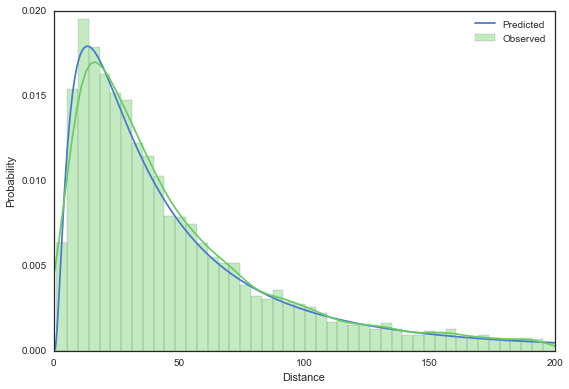

In [13]:
distances = LognormalUncertainty.from_dicts(
    {
        'loc': np.log(36.7),
        'scale': 1,
        'maximum': 200,
    }
)

plt.plot(*LognormalUncertainty.pdf(distances, np.linspace(0, 200, 1e4)), label="Predicted")
plt.xlabel("Distance")
plt.ylabel("Probability")

distances = LognormalUncertainty.bounded_random_variables(distances, size=population).ravel()
sns.distplot(distances, label="Observed")
plt.legend()
plt.xlim(0, 200)
plt.tight_layout()

print("Created array of distances with shape:", distances.shape)

Next, we need to figure out how many trips people take - they can take a different vehicle for each trip.

Let's assume that everyone can take between 1 and 5 trips. We will split up the distances randomly.

In [14]:
trip_distances = (np.random.random(size=(population* 5))
                           .reshape((population, 5)))

trip_occured = ((np.random.random(size=(population * 4)) > 0.5)    
                          .reshape((population, 4))) * 1

trip_distances[:, 1:] = trip_distances[:, 1:] * [trip_occured]

OK, so we now have

Each row (person) should be normalized to sum to one:

In [15]:
trip_distances = trip_distances / trip_distances.sum(axis=1).reshape((-1, 1))

And multiplied by the distance that person goes each day.

In [16]:
trip_distances *= distances.reshape((-1, 1))

In [17]:
print("Total number of actual trips:", (trip_distances > 0).sum())

Total number of actual trips: 30050


Let's visualize our distance distributions:

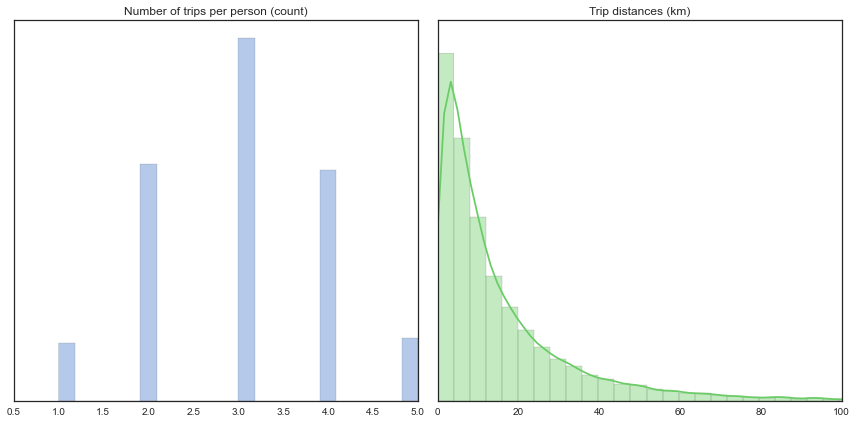

In [18]:
f, axes = plt.subplots(1, 2, figsize=(12, 6))

num_trips = axes[0]
trip_hist = axes[1]

mask = trip_distances > 0

sns.distplot(mask.sum(axis=1), kde=False, ax=num_trips)
num_trips.set_title("Number of trips per person (count)")

sns.distplot(trip_distances[mask], color="g", ax=trip_hist)
trip_hist.set_title("Trip distances (km)")
trip_hist.set_xlim(0, 100)

plt.setp(axes, yticks=[])
plt.tight_layout()

We assume that the fraction of trips taken by bicycle goes down linearly with distance to 25 km, and similarly with electric bicycle down to 50 km. There is also only an 0.8 chance that any given trip possible with bike or electric bike will be taken due to e.g. weather.

In [19]:
chance_bicycle = (1 - trip_distances / 30) * 0.8
# Eliminate non-trips where distance = 0
chance_bicycle[chance_bicycle == 0.8] = 0 
# Turn probabilities into boolean array of possible true or falses
chance_bicycle = (chance_bicycle > np.random.random(size=(population * 5))
                                            .reshape(chance_bicycle.shape)) 
print(chance_bicycle.sum())

13861


In [20]:
chance_ebike = (1 - trip_distances / 100) * 0.8
chance_ebike[chance_ebike == 0.8] = 0
chance_ebike = (chance_ebike > np.random.random(size=(population * 5))
                                        .reshape(chance_ebike.shape)) 
print(chance_ebike.sum())

20106


Again following the microcensus, there is a 0.7 chance that one has a bicycle, and a 0.8 chance that one has a car. We will assign these at random.

In [21]:
has_bicycle = np.random.random(size=population) < 0.7
has_car = np.random.random(size=population) < 0.8

Each trip has an 0.8 chance of being possible using public transport.

In [22]:
can_use_ov = (np.random.random(size=(population * 5))
                       .reshape(chance_ebike.shape)) > 0.2

There are also 20% of the population that are against cars, and will pay an additional penalty for private car use.

In [23]:
against_cars = np.random.random(size=population) < 0.2

We can now define our model (finally!). Actually, this is the easy part - most of the work in optimization is getting the input data in a reasonable state, and checking your assumptions. Well, and doing sensitivity analysis of your input parameters, uncertainty analysis of your results, and then choosing algorithms... there are a lot of "most of the work" elements, I guess.

Our model will be semi-agent based. Each person will evaluate all possible options, and choose the lowest cost for their preferences and trip schedule. The options are:

1. Buy new car + sell old car
2. Buy electric bicycle

We assume that if you don't have a bicycle already, you don't want one.

However, for each trip we will still need to choose between old car, new car, bicycle, electric bicycle, car share, and public transport.

In [24]:
import collections

fields = (
    "bike_used", 
    "ebike_bought", 
    "ebike_used", 
    "new_car_bought", 
    "new_car_used", 
    "old_car_sold", 
    "old_car_used", 
    "ov_used", 
    "car_sharing_used",
)

ModelResult = collections.namedtuple('ModelResult', fields)

In [73]:
class TransportEvaluator(object):
    def __init__(self, distances, costs, has_bicycle, has_car, ov_trips, 
                 bike_trips, ebike_trips, against_cars):
        """Set up model with input parameters, and calculate preliminary cost arrays"""
        self.distances = distances        # 2-d array; population by trips
        self.costs = costs                # dictionary
        self.has_bicycle = has_bicycle    # Boolean array; 1-d (population)
        self.has_car = has_car            # Boolean array; 1-d (population)
        self.ov_trips = ov_trips          # Boolean array; can use public transport; population by trips
        self.bike_trips = bike_trips      # Boolean array; can use bike; population by trips
        self.ebike_trips = ebike_trips    # Boolean array; can use bike; population by trips
        self.against_cars = against_cars  # Boolean array; 1-d (population)

        self.labels = [
            "New car", 
            "Sell car", 
            "Sell car, buy ebike", 
            "Buy all", 
            "Buy ebike", 
            "Status Quo"
        ]

        self.option_kwargs = [
            {"buy_new_car": True},
            {"sell_car": True},
            {"sell_car": True, "buy_ebike": True},
            {"buy_new_car": True, "buy_ebike": True},
            {"buy_ebike": True},
            {}
        ]
    
        self.options = self.calculate_all_options()

    def __call__(self, ebike_premium=0.):
        """Call the model. 

        ``ebike_premium`` is financial incentive offered to ebike purchase."""
        mr, costs = self.best_model_result(ebike_premium)
        return costs.sum() + mr.ebike_bought.sum() * ebike_premium

    def choose_best_option(self, options):
        return np.argsort(np.hstack(options).reshape((6, -1)), axis=0)[0, :]

    def construct_empty_model_result(self):
        return ModelResult(
            np.zeros(self.distances.shape, dtype=bool),
            np.zeros(self.distances.shape[0], dtype=bool),
            np.zeros(self.distances.shape, dtype=bool),
            np.zeros(self.distances.shape[0], dtype=bool),
            np.zeros(self.distances.shape, dtype=bool),
            np.zeros(self.distances.shape[0], dtype=bool),
            np.zeros(self.distances.shape, dtype=bool),
            np.zeros(self.distances.shape, dtype=bool),
            np.zeros(self.distances.shape, dtype=bool),
        )

    def add_rows(self, in_mr, out_mr, mask):
        one_d_attrs = ["ebike_bought", "new_car_bought", "old_car_sold"]
        two_d_attrs = ["bike_used", "ebike_used", "new_car_used", "old_car_used", "ov_used", "car_sharing_used"]
        for attr in one_d_attrs:
            getattr(out_mr, attr)[mask] = getattr(in_mr, attr)[mask]
        for attr in two_d_attrs:
            getattr(out_mr, attr)[mask, :] = getattr(in_mr, attr)[mask, :]

    def best_model_result(self, premium):
        all_costs = self.evalulate_all_options(premium)
        choices = self.choose_best_option(all_costs)
        costs = np.hstack(all_costs).reshape((6, -1))[choices, np.arange(choices.shape[0])]
        result = self.construct_empty_model_result()

        for index in range(6):
            mask = choices == index
            self.add_rows(self.options[index], result, mask)

        return result, costs

    def calculate_all_options(self):
        return [self.allocate_transport(**kwargs) for kwargs in self.option_kwargs]

    def evalulate_all_options(self, premium):
        return [self.calculate_costs(obj, premium) for obj in self.options]

    def calculate_costs(self, mr, premium, split=False):
        """Calculate costs for a model result. 

        Premium is subtracted from each ebike purchase price."""
        values = [
            # Bicycle maintenance
            (mr.bike_used.sum(axis=1) > 0) * self.costs['bike maintenance'],
            # Ebike cost, including maintenance
            mr.ebike_bought.astype(float) * (self.costs['ebike'] - premium), 
            # Ebike operating cost
            (mr.ebike_used * self.distances).sum(axis=1) * self.costs['electricity'] * days,
            # New car purchase
            mr.new_car_bought * self.costs['new car'],
            # New car operating cost
            (mr.new_car_used * self.distances).sum(axis=1) * self.costs['new car km'] * days,
            # Old car operating cost
            (mr.old_car_used * self.distances).sum(axis=1) * self.costs['old car km'] * days,
            # Old car resale
            -1 * mr.old_car_sold * self.costs['old car resale'],
            # Car penalty
            ((mr.old_car_used + mr.new_car_used).sum(axis=1) > 0) * self.against_cars * self.costs['green penalty'],
            # Public transport
            (mr.ov_used * self.distances).sum(axis=1) * self.costs['postbus'] * days,
            # Car sharing
            (mr.car_sharing_used * self.distances).sum(axis=1) * self.costs['car sharing'] * days
        ]
        if split:
            return values
        else:
            return sum(values)

    def allocate_transport(self, buy_new_car=False, buy_ebike=False, sell_car=False):
        """Allocate transport using precedence order list.

        Choose transport from the lowest to highest cost, namely:

        * bike
        * electric bike
        * new car
        * old car
        * public transport
        * car sharing

        ebike is only available if ``buy_ebike``.
        new car is only available if ``buy_new_car``.
        new and old car are removed if ``sell_car``.

        This is a silly algorithm, but the whole model is made up, so...

        """
        # If bicycle available, use bicycle when possible
        trips = self.distances.copy()
        bike_used = np.ones(shape=trips.shape, dtype=bool)
        bike_used[~self.has_bicycle, :] = False  # No bike, can't use it
        bike_used[~self.bike_trips] = False      # Trip not suitable for bike
        trips[bike_used] = 0

        # Buy and use ebike, if possible
        ebike_used = np.ones(shape=trips.shape, dtype=bool)
        if buy_ebike:
            ebike_used[~bike_used] = False             # Trip already taken with bike
            ebike_used[~self.ebike_trips] = False      # Trip not suitable for ebike
            trips[ebike_used] = 0
        else:
            ebike_used *= False          

        if not sell_car:
            if buy_new_car:
                new_car_used = trips.astype(bool)
                old_car_used = trips.astype(bool) * False
                trips = trips.astype(bool) * False
            else:
                new_car_used = trips.astype(bool) * False
                old_car_used = trips.astype(bool) * self.has_car.reshape((-1, 1))
                trips[old_car_used] = 0
        else:
            old_car_used = trips.astype(bool) * False
            new_car_used = trips.astype(bool) * False

        ov = trips.astype(bool) * self.ov_trips
        trips[ov] = 0
        mobility = trips.astype(bool)  # All remaining

        return ModelResult(
            bike_used,
            ebike_used.sum(axis=1) > 0,
            ebike_used,
            new_car_used.sum(axis=1) > 0,
            new_car_used,
            self.has_car * (True if (sell_car or buy_new_car) else False),
            old_car_used, 
            ov,
            mobility
        )

In [74]:
te = TransportEvaluator(
    trip_distances, 
    costs, 
    has_bicycle,
    has_car,
    can_use_ov,
    chance_bicycle,
    chance_ebike,
    against_cars
)

Let's investigate how much the different options cost.

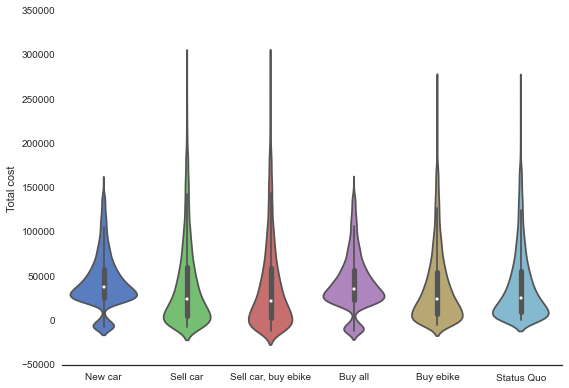

In [70]:
sns.violinplot(data=te.evalulate_all_options(10000.))
sns.despine(left=True)
plt.ylabel("Total cost")
plt.xticks(range(6), te.labels)
plt.tight_layout()

Why do the ebike options cost so much?

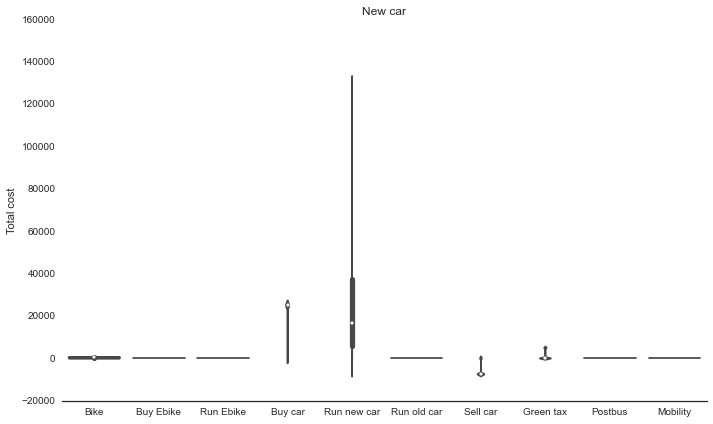

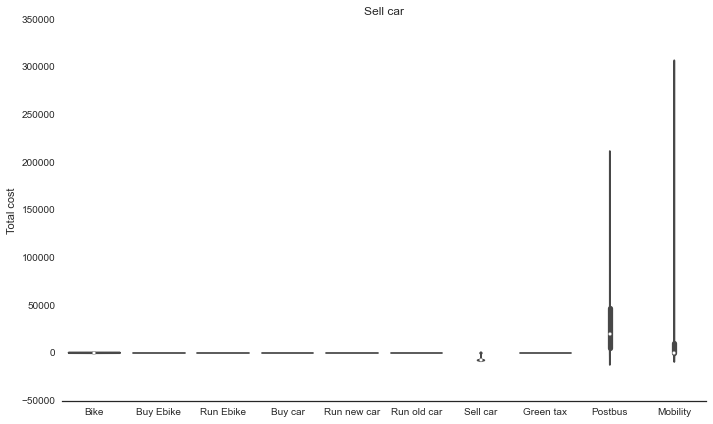

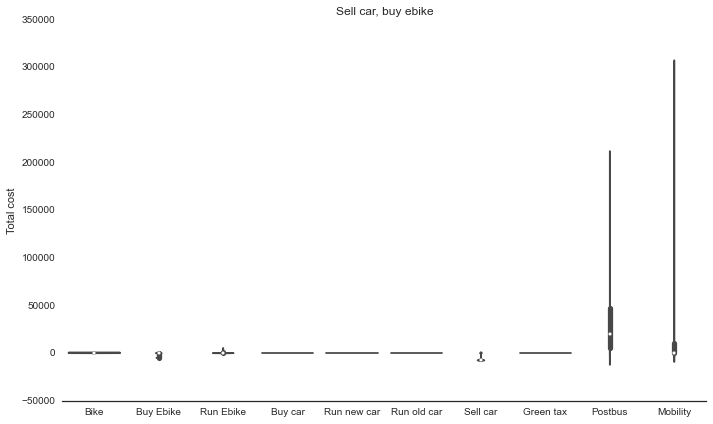

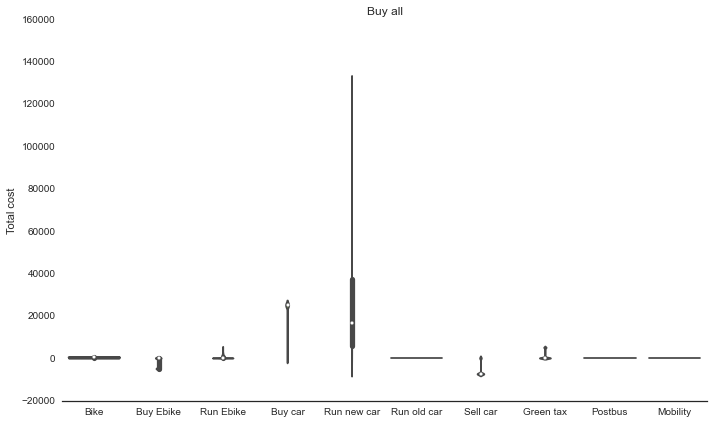

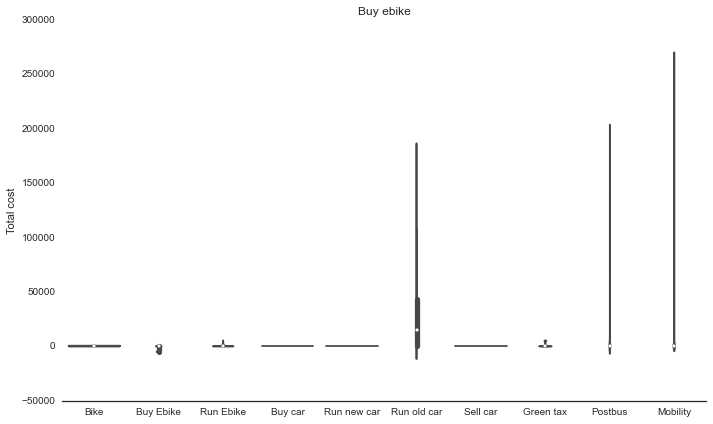

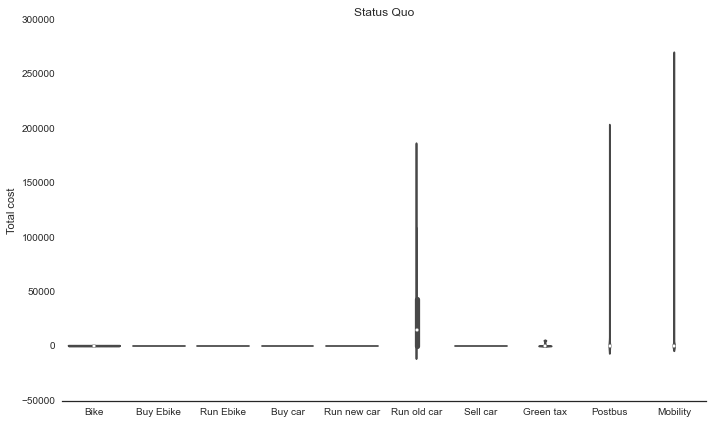

In [71]:
for label, options in zip(te.labels, te.option_kwargs):
    plt.figure(figsize=(10, 6))
    plt.title(label)
    sns.violinplot(data=te.calculate_costs(te.allocate_transport(**options), 10000., split=True))
    sns.despine(left=True)
    plt.ylabel("Total cost")
    plt.xticks(
        range(10), 
        ["Bike", "Buy Ebike", "Run Ebike", "Buy car", "Run new car", "Run old car", "Sell car", "Green tax", "Postbus", "Mobility"]
    )
    plt.tight_layout()

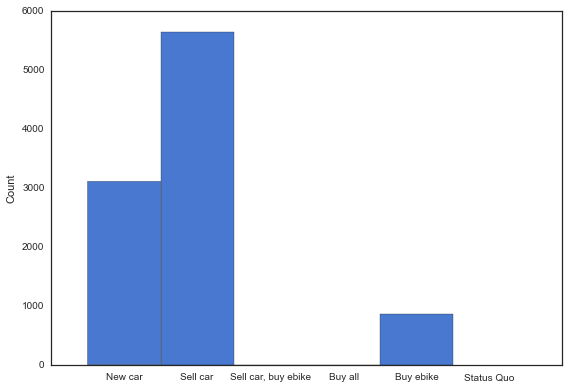

In [68]:
choices = te.choose_best_option(te.evalulate_all_options(0.))

plt.hist(choices, bins=np.arange(-0.5, 5.5, 1))
plt.xticks(range(6), te.labels)
plt.xlim(-1, 6)
plt.ylabel("Count")
plt.tight_layout()

In [69]:
best_option = te.choose_best_option(te.evalulate_all_options(0.))

for index, label in enumerate(labels):
    print(label, (best_option == index).sum())

Buy new car 3110
Sell car 5641
Only ebike 0
Buy new car and ebike 0
Buy ebike 853
Status quo 396


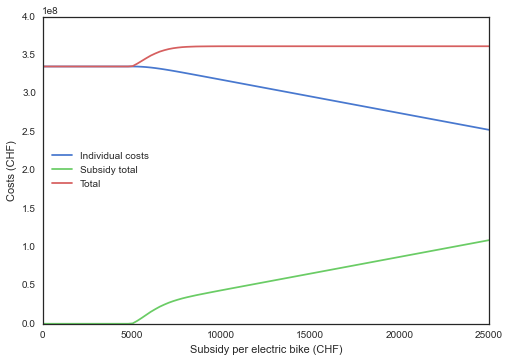

In [77]:
xs = np.linspace(0, 25000, 100)
results = [te.best_model_result(x) for x in xs]

ys1 = [obj[1].sum() for obj in results]
ys2 = [obj[0].ebike_bought.sum() * premium for premium, obj in zip(xs, results)]
ys3 = [te(x) for x in xs]

plt.plot(xs, ys1, label="Individual costs")
plt.plot(xs, ys2, 'g-', label="Subsidy total")
plt.plot(xs, ys3, 'r-', label="Total")
plt.legend(loc=6)
plt.ylabel("Costs (CHF)")
plt.xlabel("Subsidy per electric bike (CHF)")

In [11]:
db = Database("ecoinvent 2.2")

bicycle = db.search("transport, bicycle")[0]
print("Bicycle:", bicycle)
ebike = db.search("transport, electric bicycle")[0]
print("Electric bicycle:", ebike)

for x in ebike.technosphere():
    print(x)

Bicycle: 'transport, bicycle' (person kilometer, CH, ['transport systems', 'road'])
Electric bicycle: 'transport, electric bicycle' (person kilometer, CH, ['transport systems', 'road'])


OK, let's optimize!

In [79]:
from scipy.optimize import minimize

minimize(te, 6000., bounds=[[0, 1e6]])

 success: True
     nit: 1
    nfev: 4
  status: 0
       x: array([ 5994.03953552])
     jac: array([ 0.])
     fun: array([  3.48554518e+08])
 message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'

Can play around here with entering bounds and or constraints. 

One could also edit the `__call__` method to ignore values less than zero.

In [80]:
minimize(te, 6000., method="Powell", bounds=[[0, 1e6]])

 success: True
     nit: 2
    nfev: 52
  status: 0
       x: array(-18626.28210518707)
   direc: array([[-6196.32251961]])
     fun: array(335318289.8870853)
 message: 'Optimization terminated successfully.'